<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/QRS_detection_CNN%2BLSTM_50sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
#or
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [ ]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


# 2- Load an ECG Record and Its Annotations

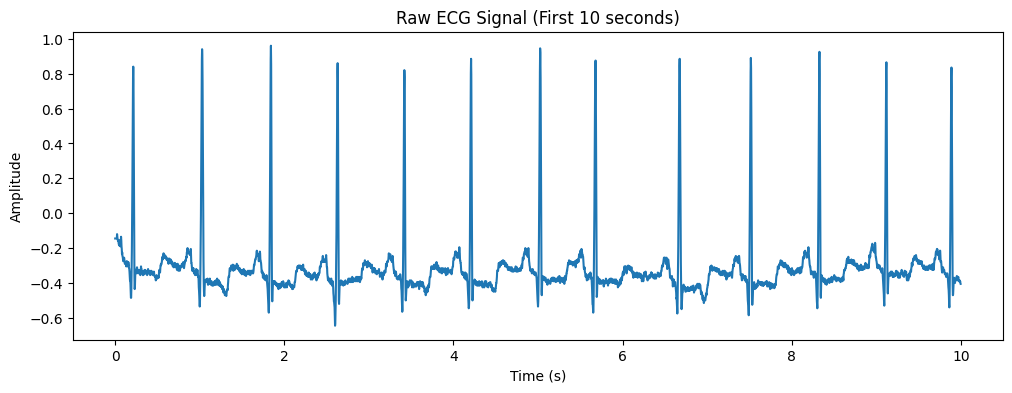

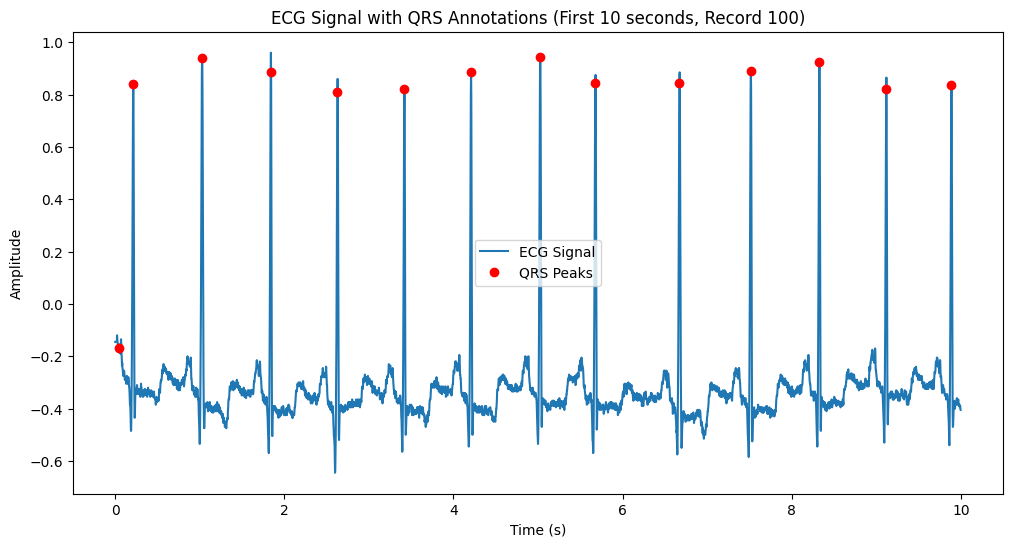

In [4]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Replace '100' with the record number you want to load
record_dir = '/content/physionet.org/files/mitdb/1.0.0/'
record_name = '100'
record_name = record_dir + record_name
record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'atr')

# Use channel 0 (if multi-channel) and get the sampling frequency (typically 360 Hz)
ecg_signal = record.p_signal[:, 0]
fs = record.fs

# Define time axis
time_axis = [i / fs for i in range(len(ecg_signal))]

# Plot the first 10 seconds of the raw ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs*10], ecg_signal[:fs*10])
plt.title("Raw ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot ECG with QRS annotations (also limited to the first 10s)
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], ecg_signal[:fs*10], label="ECG Signal")

# Filter QRS annotations within the first 10s
qrs_indices_10s = annotation.sample[annotation.sample < fs*10]
qrs_values_10s = record.p_signal[qrs_indices_10s, 0]

# Plot QRS peaks
time_axis = np.array(time_axis)  # Convert to NumPy array
plt.plot(time_axis[qrs_indices_10s], qrs_values_10s, 'ro', label='QRS Peaks')


plt.title("ECG Signal with QRS Annotations (First 10 seconds, Record 100)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


# 3- Preprocess the Signal

## A. Filtering

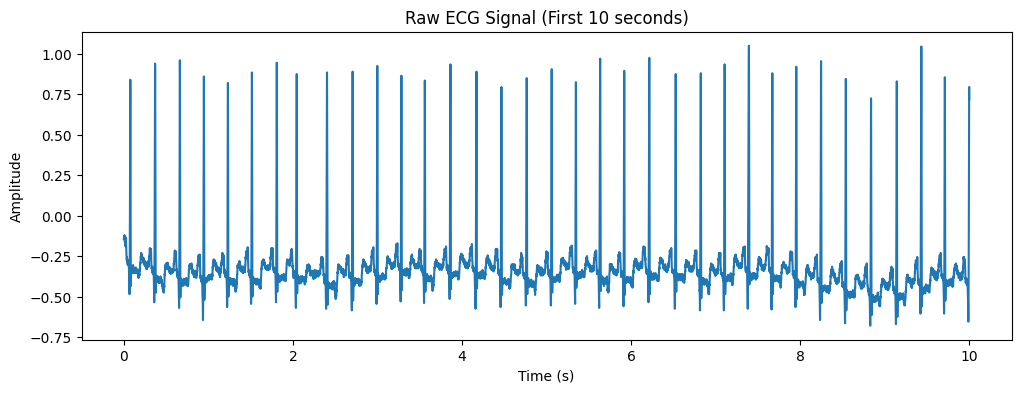

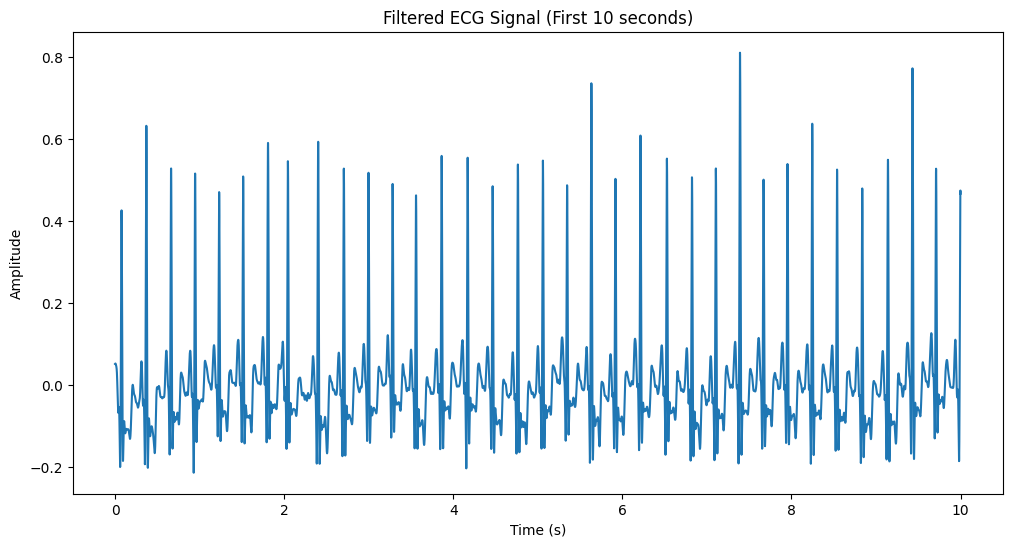

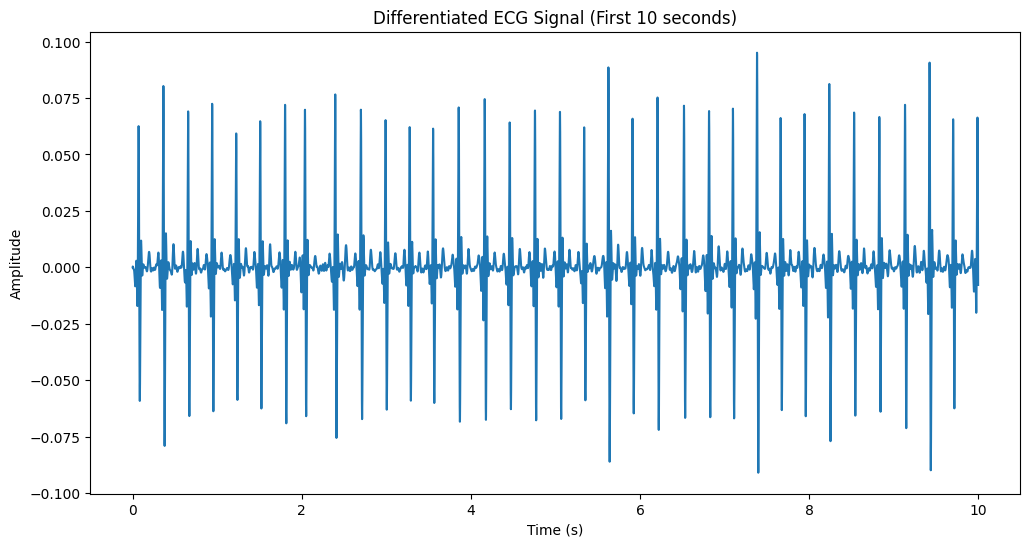

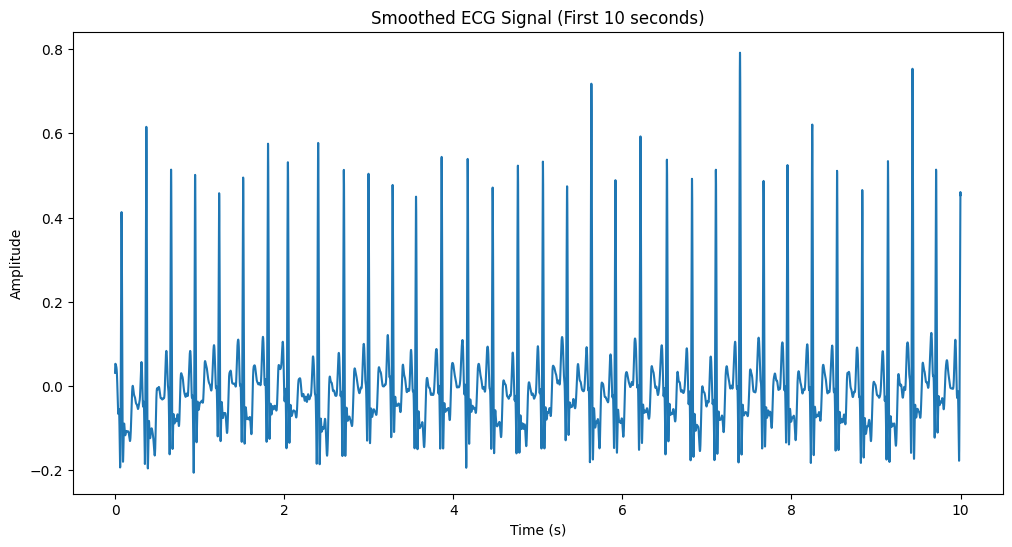

In [5]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def differentiate_signal(data, fs):
    # Differentiate the signal using a first-order difference
    differentiated = np.diff(data, prepend=data[0])
    return differentiated

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

# Example usage
fs = 1000  # Sampling frequency in Hz
time_axis = np.arange(0, len(ecg_signal)) / fs  # Time axis in seconds

# Apply bandpass filter
filtered_signal = bandpass_filter(ecg_signal, fs)

# Optionally differentiate the signal
differentiated_signal = differentiate_signal(filtered_signal, fs)

# Optionally smooth the signal
smoothed_signal = smooth_signal(filtered_signal, window_size=5)

# Plot the first 10 seconds of the raw ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs*10], ecg_signal[:fs*10])
plt.title("Raw ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], filtered_signal[:fs*10])
plt.title("Filtered ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot differentiated signal (optional)
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], differentiated_signal[:fs*10])
plt.title("Differentiated ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot smoothed signal (optional)
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], smoothed_signal[:fs*10])
plt.title("Smoothed ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## B. Normalization

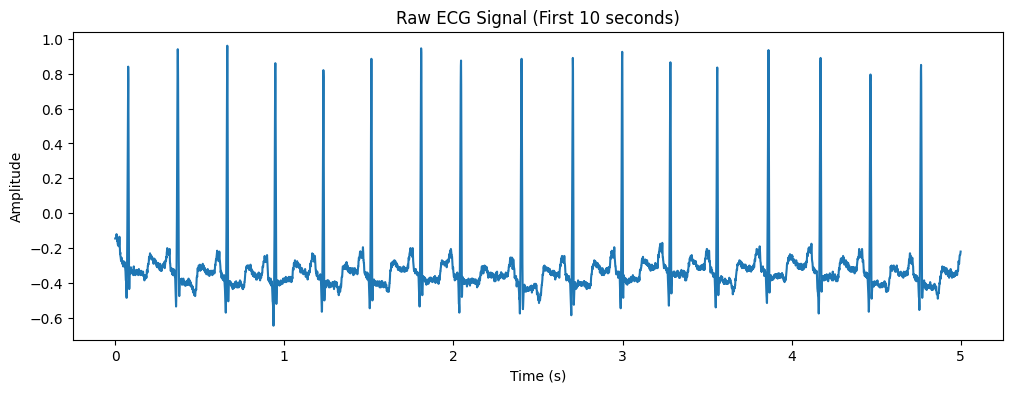

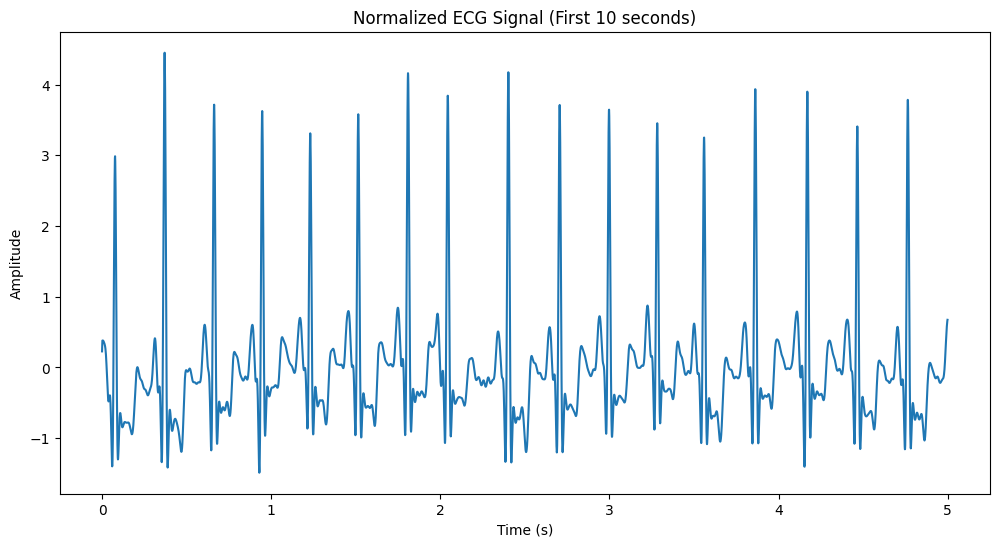

In [6]:
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

# Normalize the smoothed signal
normalized_signal = normalize_signal(smoothed_signal)

# Plot the first 10 seconds of the raw ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs*5], ecg_signal[:fs*5])
plt.title("Raw ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot the normalized signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*5], normalized_signal[:fs*5])
plt.title("Normalized ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# 4- Segment the Signal for QRS Detection

In [7]:
import numpy as np

def segment_signal(signal, window_size=50, overlap=40):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        tuple: (Array of segmented windows, Array of segment start indices)
    """
    segments = []
    segment_indices = []

    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
        segment_indices.append(start)  # Store segment start position

    return np.array(segments), np.array(segment_indices)

# Define segmentation parameters
sampling_rate = 360  # Hz
qrs_duration = int(0.06 * sampling_rate)  # ~22 samples for QRS
window_size = 50  # Window size in samples
overlap = 40  # Overlap should be at least QRS duration

# Apply segmentation
segmented_signal, segment_starts = segment_signal(normalized_signal, window_size=window_size, overlap=overlap)

print(f"Extracted {len(segmented_signal)} segments with window size {window_size} and {overlap} samples overlap.")


Extracted 64996 segments with window size 50 and 40 samples overlap.


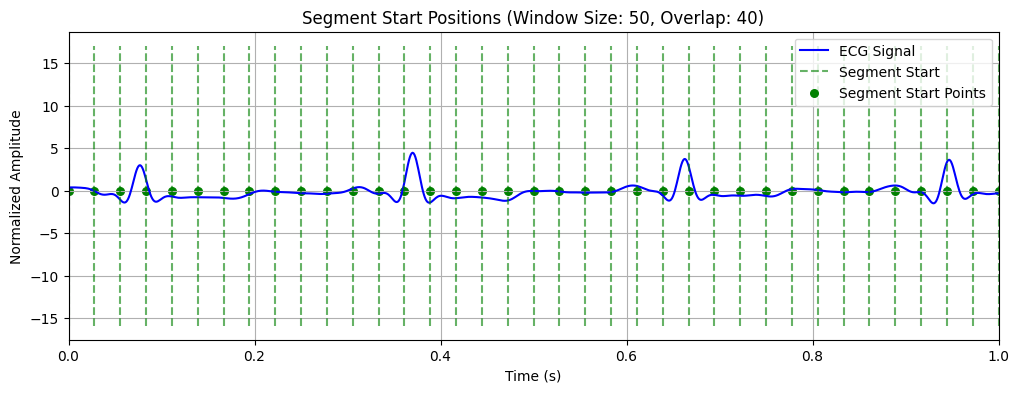

In [8]:
# Convert sample indices to time (seconds)
time_starts = segment_starts / sampling_rate

# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

# Mark segment start positions
plt.vlines(time_starts, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")
plt.scatter(time_starts, np.zeros_like(time_starts), color="green", marker="o", s=30, label="Segment Start Points")

# Zoom in on a specific range (adjust as needed)
zoom_start, zoom_end = 0.0, 1.0
plt.xlim(zoom_start, zoom_end)

plt.title(f"Segment Start Positions (Window Size: {window_size}, Overlap: {overlap})")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.grid()
plt.show()
#[0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

# 5- Prepare the Dataset for the CNN + LSTM Model

## A. Labeling and Combining the Data

In [9]:
import numpy as np

def label_segments(normalized_signal,segments, segment_starts, qrs_indices, window_size=50, overlap=25):
    """
    Label each segment as QRS (1) or non-QRS (0), ensuring an equal number of 0 and 1 labels.

    Args:
        segments (np.array): Array of segmented windows.
        segment_starts (np.array): Start indices of segments.
        qrs_indices (list): List of QRS indices (in samples).
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        np.array: Array of labels (1 for QRS, 0 for non-QRS).
    """
    labels = np.zeros(len(segments), dtype=int)
    q_offset = 18  # Offset to cover full QRS complex

    # Label QRS segments
    for i, segment_start in enumerate(segment_starts):
        segment_end = segment_start + window_size

        # Check if any QRS index falls within this segment
        for r_peak in qrs_indices:
            q_start = r_peak - q_offset  # Approximate Q start
            s_end = r_peak + q_offset    # Approximate S end

            # Ensure q_start and s_end are within bounds
            q_start = max(0, q_start)
            s_end = min(len(normalized_signal) - 1, s_end)

            if segment_start <= q_start and segment_end >= s_end:
                labels[i] = 1
                break

    # Balance the dataset by randomly sampling non-QRS segments
    qrs_count = np.sum(labels == 1)  # Number of QRS segments
    non_qrs_indices = np.where(labels == 0)[0]  # Indices of non-QRS segments

    # Randomly sample non-QRS segments to match the number of QRS segments
    if len(non_qrs_indices) > qrs_count:
        sampled_non_qrs_indices = np.random.choice(non_qrs_indices, size=qrs_count, replace=False)
        labels[sampled_non_qrs_indices] = 0  # Ensure sampled non-QRS segments are labeled as 0
    else:
        print("Warning: Not enough non-QRS segments to balance the dataset.")

    return labels


# Filter the annotation symbols to include only typical QRS types (adjust as needed)
qrs_symbols = ['N', 'L', 'R', 'V', 'A']  # Common QRS annotation symbols
qrs_indices = [s for s, sym in zip(annotation.sample, annotation.symbol) if sym in qrs_symbols]

# Label the segments using actual segment start positions
segment_labels = label_segments( normalized_signal, segmented_signal, segment_starts, qrs_indices, window_size=50, overlap=40)
print(f"Segment labels: {segment_labels}")
print(f"Number of QRS segments: {np.sum(segment_labels == 1)}")
print(f"Number of non-QRS segments: {np.sum(segment_labels == 0)}")


Segment labels: [0 0 0 ... 0 0 1]
Number of QRS segments: 3409
Number of non-QRS segments: 61587


In [10]:
import numpy as np
import matplotlib.pyplot as plt
def display_segment(z_start,z_end):
  # Define sampling rate
  sampling_rate = 360  # Hz

  # Define zoom window in **seconds**
  zoom_start_sec = z_start   # Start time in seconds
  zoom_end_sec = z_end     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * sampling_rate  # Convert to sample index
  zoom_end = zoom_end_sec * sampling_rate      # Convert to sample index

  # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

  # Identify segment start and end in samples
  positive_windows = [(segment_starts[i], segment_starts[i] + window_size) for i in range(len(segment_labels)) if segment_labels[i] == 1]
  negative_windows = [(segment_starts[i], segment_starts[i] + window_size) for i in range(len(segment_labels)) if segment_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(normalized_signal)) / sampling_rate  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
      plt.axvspan(start / sampling_rate, end / sampling_rate, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

  # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / sampling_rate, end / sampling_rate, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / sampling_rate, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


Number of positive (QRS) segments: 3409
Number of negative (non-QRS) segments: 61587


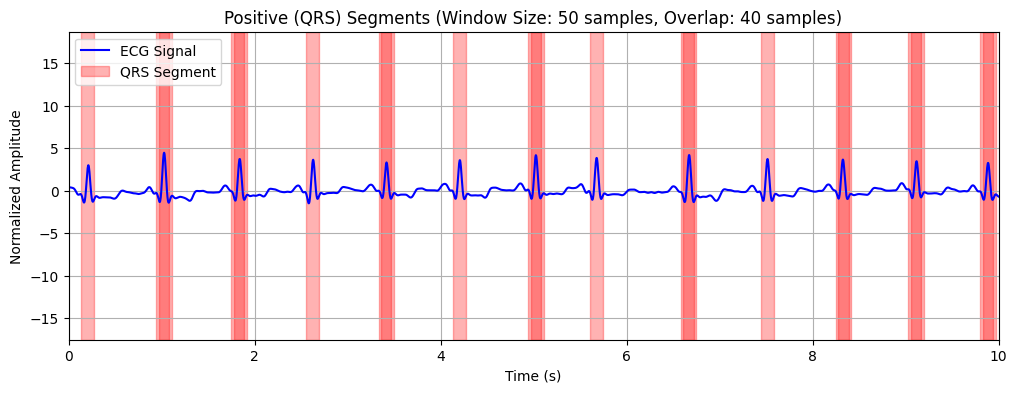

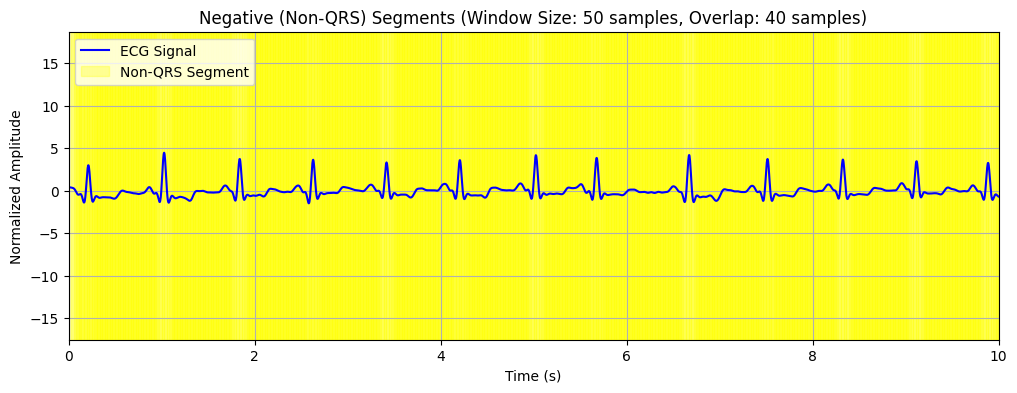

In [11]:
display_segment(0,10)

## B. traitement dataset

In [12]:
def remove_consecutive_ones(segment_labels, segmented_signal, segment_starts):
    filtered_labels = []
    filtered_signal = []
    filtered_starts = []

    i = 0
    while i < len(segment_labels)-1:
        if segment_labels[i] == 1:
            # Find the range of consecutive ones
            start = i
            while i + 1 < len(segment_labels) and segment_labels[i + 1] == 1:
                i += 1
            end = i

            # Compute the middle index of the block
            mid = (start + end) // 2

            # Keep only the middle one
            filtered_labels.append(segment_labels[mid])
            filtered_signal.append(segmented_signal[mid])
            filtered_starts.append(segment_starts[mid])

        else:
            # Keep zeros as they are
            filtered_labels.append(segment_labels[i])
            filtered_signal.append(segmented_signal[i])
            filtered_starts.append(segment_starts[i])

        i += 1  # Move to the next segment

    return filtered_labels, filtered_signal, filtered_starts

segment_labels, segmented_signal, segment_starts = remove_consecutive_ones(segment_labels, segmented_signal, segment_starts)

Number of positive (QRS) segments: 2272
Number of negative (non-QRS) segments: 61587


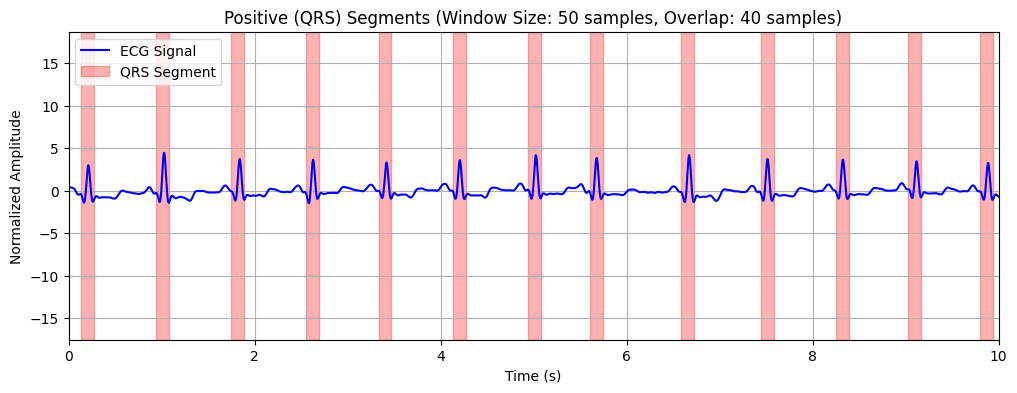

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


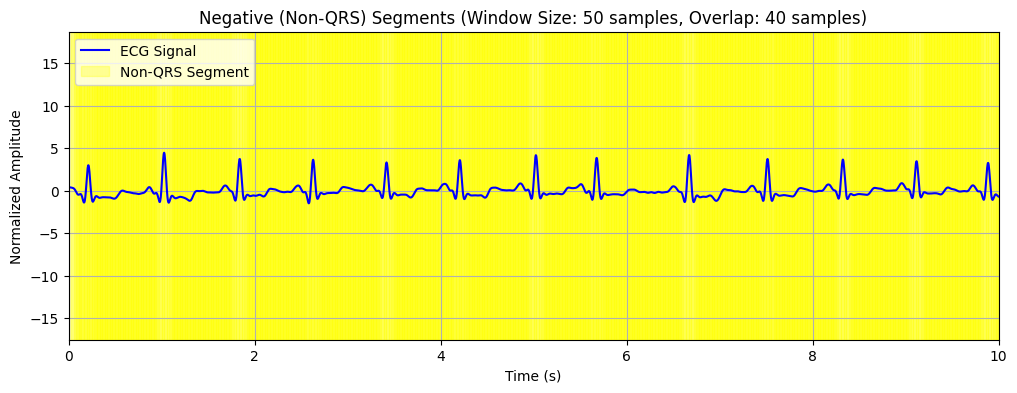

In [13]:
display_segment(0,10)

In [14]:
def remove_touching_negatives(segment_labels, segmented_signal, segment_starts):
    new_labels = segment_labels[:]  # Copy original lists
    new_signal = segmented_signal[:]
    new_starts = segment_starts[:]

    to_remove = set()  # Indices to remove

    for i, label in enumerate(segment_labels):
        if label == 1:  # If it's a positive window
            # Mark 4 windows before and after for removal
            for j in range(max(0, i - 4), min(len(segment_labels), i + 5)):
                if segment_labels[j] == 0:  # Only remove negatives
                    to_remove.add(j)

    # Remove marked indices
    new_labels = [label for i, label in enumerate(segment_labels) if i not in to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in to_remove]

    return new_labels, new_signal, new_starts

# Example usage:
segment_labels, segmented_signal, segment_starts = remove_touching_negatives(segment_labels, segmented_signal, segment_starts)


Number of positive (QRS) segments: 2272
Number of negative (non-QRS) segments: 43411


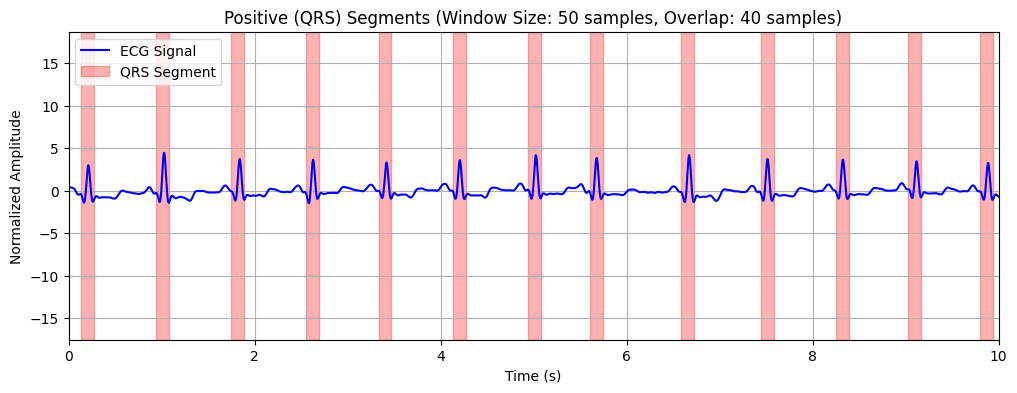

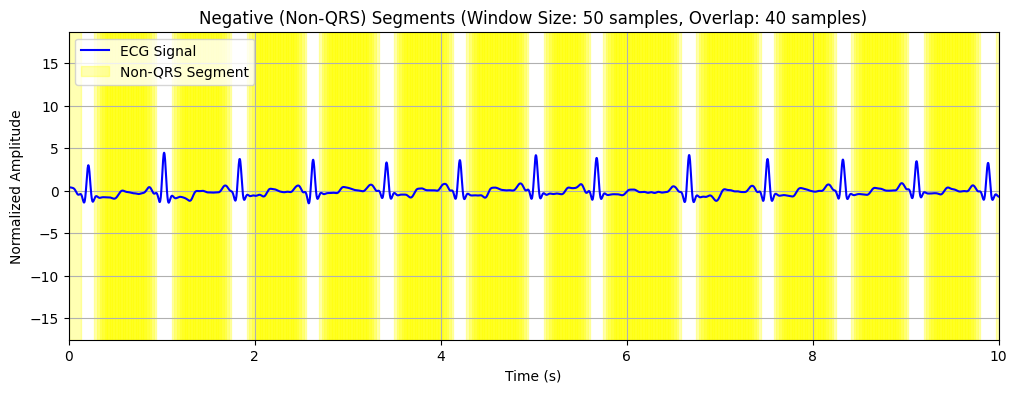

In [15]:
display_segment(0,10)


In [16]:
import random

def balance_classes(segment_labels, segmented_signal, segment_starts):
    # Count positive and negative instances
    num_positives = sum(1 for label in segment_labels if label == 1)
    num_negatives = sum(1 for label in segment_labels if label == 0)

    # If negatives are already balanced, return as is
    if num_negatives <= num_positives:
        return segment_labels, segmented_signal, segment_starts

    # Get indices of negative samples
    negative_indices = [i for i, label in enumerate(segment_labels) if label == 0]

    # Randomly select indices to remove
    num_to_remove = num_negatives - num_positives
    indices_to_remove = set(random.sample(negative_indices, num_to_remove))

    # Remove selected negatives while keeping lists synchronized
    new_labels = [label for i, label in enumerate(segment_labels) if i not in indices_to_remove]
    new_signal = [signal for i, signal in enumerate(segmented_signal) if i not in indices_to_remove]
    new_starts = [start for i, start in enumerate(segment_starts) if i not in indices_to_remove]

    return new_labels, new_signal, new_starts

# Example usage:
segment_labels, segmented_signal, segment_starts = balance_classes(segment_labels, segmented_signal, segment_starts)


Number of positive (QRS) segments: 2272
Number of negative (non-QRS) segments: 2272


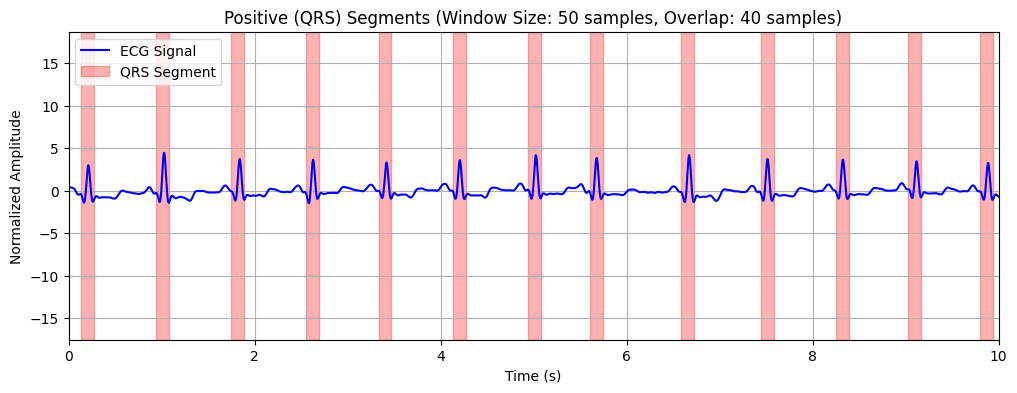

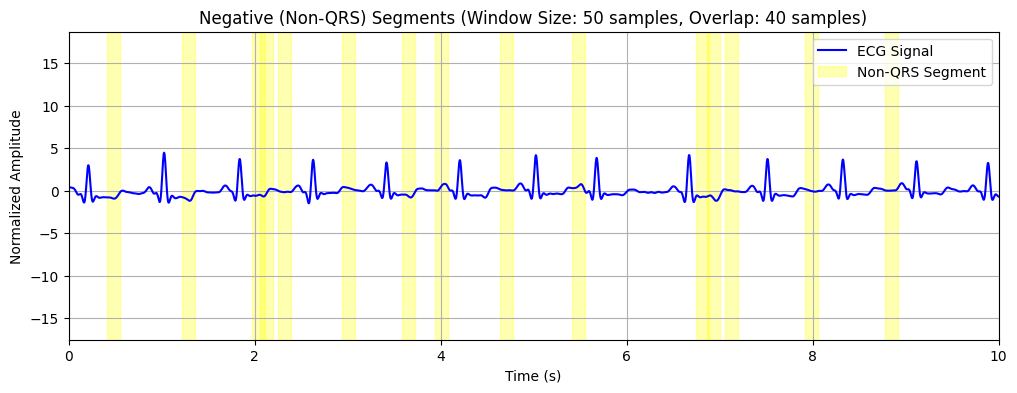

In [17]:
display_segment(0,10)


In [18]:
segment_labels = np.array(segment_labels)
segmented_signal = np.array(segmented_signal)
segment_starts = np.array(segment_starts)

## C. Shuffle and Reshape Data

In [19]:
from sklearn.utils import shuffle
import numpy as np

# Shuffle the data
all_segments, all_labels = shuffle(segmented_signal, segment_labels, random_state=42)

# Reshape to (num_samples, window_length, 1)
all_segments = all_segments.reshape(all_segments.shape[0], all_segments.shape[1], 1)
print("Reshaped data for CNN+LSTM:", all_segments.shape)

# Ensure all_labels is a 1D array
all_labels = np.array(all_labels).flatten()  # Convert to 1D array if it's not already
print("Shape of all_labels:", all_labels.shape)

# Separate positive and negative segments
positive_segments = all_segments[all_labels == 1]  # Index using the 1D boolean array
negative_segments = all_segments[all_labels == 0]

# Undersample the majority class (negative segments)
num_positive = len(positive_segments)
negative_segments_balanced = negative_segments[:num_positive]  # Take the same number as positive segments

# Combine balanced positive and negative segments
balanced_segments = np.concatenate([positive_segments, negative_segments_balanced])
balanced_labels = np.concatenate([np.ones(num_positive), np.zeros(num_positive)])  # Labels: 1 for QRS, 0 for non-QRS

# Shuffle the balanced dataset
balanced_segments, balanced_labels = shuffle(balanced_segments, balanced_labels, random_state=42)

# Reshape to (num_samples, window_length, 1)
balanced_segments = balanced_segments.reshape(balanced_segments.shape[0], balanced_segments.shape[1], 1)
print("Balanced data shape:", balanced_segments.shape)

Reshaped data for CNN+LSTM: (4544, 50, 1)
Shape of all_labels: (4544,)
Balanced data shape: (4544, 50, 1)


## D. Split

In [20]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_segments, balanced_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (2726, 50, 1) (2726,)
Validation: (909, 50, 1) (909,)
Test: (909, 50, 1) (909,)


In [21]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (2726, 50, 1)
Shape of y_train: (2726,)


In [22]:
# Reshape y_train, y_val, and y_test to match the model's output shape
y_train = y_train.reshape(-1, 1, 1)  # Shape: [num_samples, 1, 1]
y_val = y_val.reshape(-1, 1, 1)      # Shape: [num_samples, 1, 1]
y_test = y_test.reshape(-1, 1, 1)    # Shape: [num_samples, 1, 1]

# Verify shapes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (2726, 50, 1) (2726, 1, 1)
Validation: (909, 50, 1) (909, 1, 1)
Test: (909, 50, 1) (909, 1, 1)


In [23]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [24]:
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("Inf in y_train:", np.isinf(y_train).any())

NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False


# 6- Build the Hybrid CNN + LSTM Model

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Flatten, Reshape,
    Bidirectional, LSTM, Dense, Dropout, TimeDistributed
)
# Parameters
window_length = 50  # Fixed window length (e.g., 250 samples)
input_shape = (window_length, 1)  # Input shape: (batch_size, 250, 1)

# Define the CNN + LSTM model architecture
model = Sequential()

# --- CNN layers ---
# Input shape: (250, 1)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# --- Flatten and reshape for LSTM ---
model.add(Flatten())

# Automatically calculate the flattened shape
flattened_shape = model.output_shape[1]  # Get the shape after Flatten
print(f"Flattened shape: {flattened_shape}")

# Reshape to (timesteps, features) for LSTM
model.add(Reshape((1, flattened_shape)))  # Reshape dynamically

# --- Bidirectional LSTM layer ---
model.add(Bidirectional(LSTM(units=100, return_sequences=True)))  # Use return_sequences=True for sequence labeling

# --- Fully Connected layers ---
model.add(TimeDistributed(Dense(50, activation='relu')))  # TimeDistributed for per-sample outputs
model.add(Dropout(0.5))

# --- Output layer ---
model.add(TimeDistributed(Dense(1, activation='sigmoid')))  # Binary classification (QRS vs. non-QRS)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Flattened shape: 512


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 46, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 23, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 23, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 21, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 8, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 200)              │         490,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 50)               │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 1)                │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 532,501 (2.03 MB)

 Trainable params: 532,053 (2.03 MB)

 Non-trainable params: 448 (1.75 KB)

# 7- Train the Model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32,
          callbacks=[early_stopping, lr_scheduler])



Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9649 - loss: 0.0977 - val_accuracy: 0.6821 - val_loss: 0.6689 - learning_rate: 0.0010
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9998 - loss: 7.2746e-04 - val_accuracy: 0.6832 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 4.6297e-04 - val_accuracy: 0.9241 - val_loss: 0.1988 - learning_rate: 0.0010
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 1.0000 - loss: 1.4011e-04 - val_accuracy: 0.9967 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 1.0000 - loss: 1.2322e-04 - val_accuracy: 1.0000 - val_loss: 7.6416e-05 - learning_rate: 0.0010
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 1.0000 - loss: 1.0025e-04 - val_accuracy: 1.0000 - val_loss: 7.5106e-06 - learning_rate: 0.0010
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.

# 8. Evaluate and Test the Model

In [27]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
# Flatten y_test and y_pred to 1D arrays
y_test_flat = y_test.reshape(-1)  # Shape: (num_samples,)
y_pred_flat = y_pred.reshape(-1)  # Shape: (num_samples,)

# Print classification report
print(classification_report(y_test_flat, y_pred_flat))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       460
         1.0       1.00      1.00      1.00       449

    accuracy                           1.00       909
   macro avg       1.00      1.00      1.00       909
weighted avg       1.00      1.00      1.00       909



In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [29]:

from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_50sample.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_50sample.h5")


# Model Test

In [85]:
from tensorflow.keras.models import load_model
# Load the model later for inference
#model = load_model("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_50sample.h5")

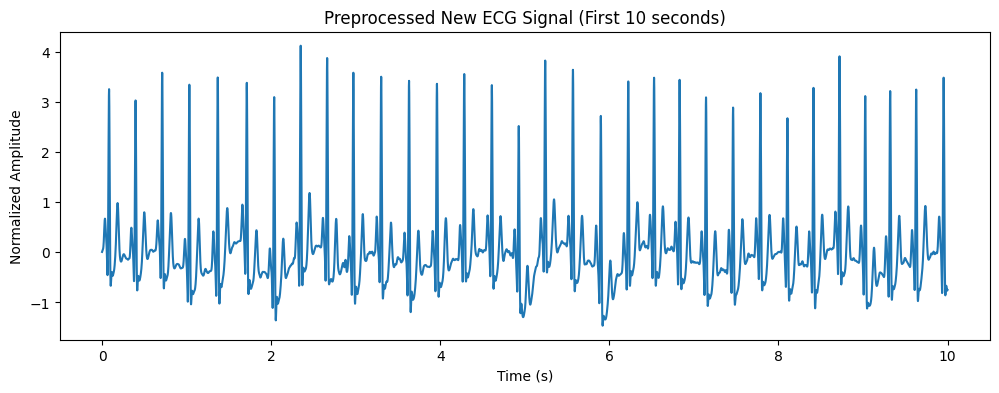

In [53]:
import wfdb
record_dir='/content/physionet.org/files/mitdb/1.0.0/'
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name='101'
new_record_name =  record_dir + new_record_name  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
fs = new_record.fs
new_annotation = wfdb.rdann(new_record_name, 'atr')
# Example usage
fs = 1000  # Sampling frequency in Hz
time_axis = np.arange(0, len(new_ecg_signal)) / fs  # Time axis in seconds

# Apply bandpass filter
new_filtered_signal = bandpass_filter(new_ecg_signal, fs)
# Optionally smooth the signal
new_smoothed_signal = smooth_signal(new_filtered_signal, window_size=5)
new_normalized_signal = normalize_signal(new_smoothed_signal)


# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs * 10], new_normalized_signal[:fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()



In [54]:


# Example usage
window_size = 50  # Fixed window size (e.g., 250 samples)
overlap = 40      # Overlap between windows (e.g., 50% overlap)

# Segment the normalized signal
new_segments,new_start_segments = segment_signal(new_normalized_signal, window_size=window_size, overlap=overlap)

print(f"Extracted {len(new_segments)} segments with window size {window_size} and {overlap} samples overlap.")



Extracted 64996 segments with window size 50 and 40 samples overlap.


In [55]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (64996, 50, 1)


In [56]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


2032/2032 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
Predicted QRS presence for each segment: [0 0 0 ... 0 0 0]


In [34]:
# Filter the annotation symbols to include only typical QRS types (adjust as needed)
new_qrs_symbols = ['N', 'L', 'R', 'V', 'A']  # Common QRS annotation symbols
new_qrs_indices = [s for s, sym in zip(new_annotation.sample, new_annotation.symbol) if sym in new_qrs_symbols]

# Label the segments using actual segment start positions
# Correct the function call to pass arguments in the correct order
real_labels = label_segments(new_normalized_signal, new_segments, new_start_segments, new_qrs_indices, window_size=50, overlap=40)

In [35]:
accuracy = (predicted_labels.flatten() == real_labels).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 95.45%


In [36]:
from sklearn.metrics import classification_report

print(classification_report(real_labels, predicted_labels.flatten()))


              precision    recall  f1-score   support

           0       1.00      0.95      0.98     62195
           1       0.49      1.00      0.65      2801

    accuracy                           0.95     64996
   macro avg       0.74      0.98      0.81     64996
weighted avg       0.98      0.95      0.96     64996



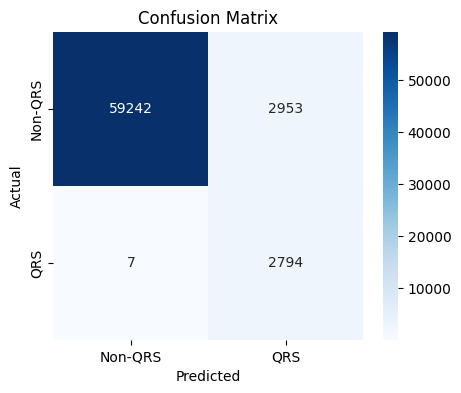

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(real_labels, predicted_labels.flatten())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-QRS", "QRS"], yticklabels=["Non-QRS", "QRS"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


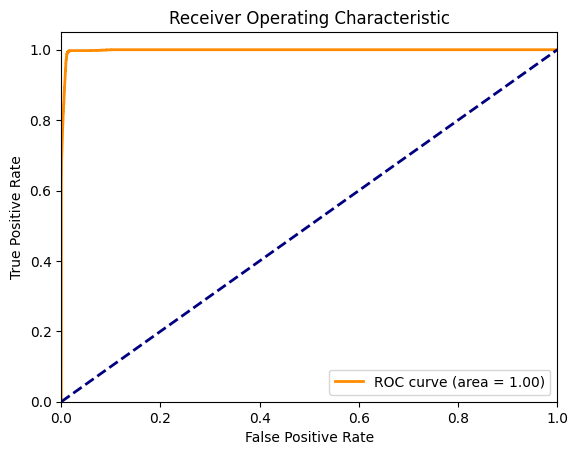

In [38]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(real_labels, predictions.flatten())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
def display_signal(start_second, end_second):
  # Define fixed-length window parameters
  window_size = 50  # Fixed window size (e.g., 250 samples)
  overlap = 40      # Overlap between windows (e.g., 50% overlap)
  half_window = window_size // 2  # Half window siz
  # Define sampling rate
  sampling_rate = 360  # Hz

  # Define zoom window in **seconds**
  zoom_start_sec = start_second   # Start time in seconds
  zoom_end_sec = end_second     # End time in seconds

  # Convert zoom window from seconds to samples
  zoom_start = zoom_start_sec * sampling_rate  # Convert to sample index
  zoom_end = zoom_end_sec * sampling_rate      # Convert to sample index

    # Function to filter windows within the zoom range (in sample indices)
  def filter_windows_in_zoom(windows, zoom_start, zoom_end):
      """Filter windows that fall within the zoom range in samples."""
      return [(start, end) for start, end in windows if start < zoom_end and end > zoom_start]

    # Identify segment start and end in samples
  positive_windows = [(new_start_segments[i], new_start_segments[i] + window_size) for i in range(len(predicted_labels)) if predicted_labels[i] == 1]
  negative_windows = [(new_start_segments[i], new_start_segments[i] + window_size) for i in range(len(predicted_labels)) if predicted_labels[i] == 0]
  print("Number of positive (QRS) segments:", len(positive_windows))
  print("Number of negative (non-QRS) segments:", len(negative_windows))
  # Filter positive and negative windows within the zoom range
  positive_windows_zoom = filter_windows_in_zoom(positive_windows, zoom_start, zoom_end)
  negative_windows_zoom = filter_windows_in_zoom(negative_windows, zoom_start, zoom_end)

  # Create time axis in **seconds**
  time_axis = np.arange(len(new_normalized_signal)) / sampling_rate  # Convert samples to seconds

  # Plot 1: Positive (QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, new_normalized_signal, label="ECG Signal", color="blue")

    # Highlight positive (QRS) windows in red (only within the zoom range)
  for start, end in positive_windows_zoom:
    plt.axvspan(start / sampling_rate, end / sampling_rate, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows_zoom[0][0] else "")

  plt.title(f"Positive (QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()

    # Plot 2: Negative (Non-QRS) Segments
  plt.figure(figsize=(12, 4))
  plt.plot(time_axis, new_normalized_signal, label="ECG Signal", color="blue")

  # Highlight negative (non-QRS) windows in yellow (only within the zoom range)
  for start, end in negative_windows_zoom:
      plt.axvspan(start / sampling_rate, end / sampling_rate, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows_zoom[0][0] else "")
      #plt.vlines(start / sampling_rate, ymin=np.min(normalized_signal), ymax=np.max(normalized_signal), color="green", linestyle="dashed", alpha=0.6, label="Segment Start")

  plt.title(f"Negative (Non-QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.xlim(zoom_start_sec, zoom_end_sec)  # Zoom in on the time range
  plt.legend()
  plt.grid()
  plt.show()


Number of positive (QRS) segments: 5747
Number of negative (non-QRS) segments: 59249


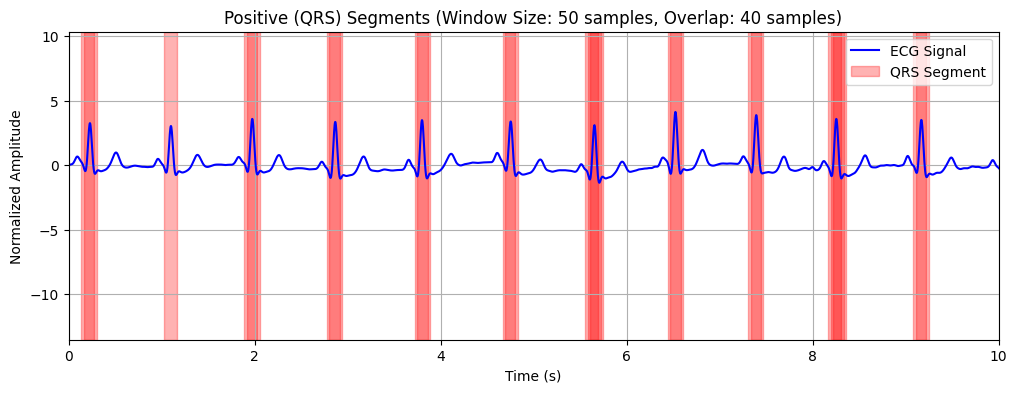

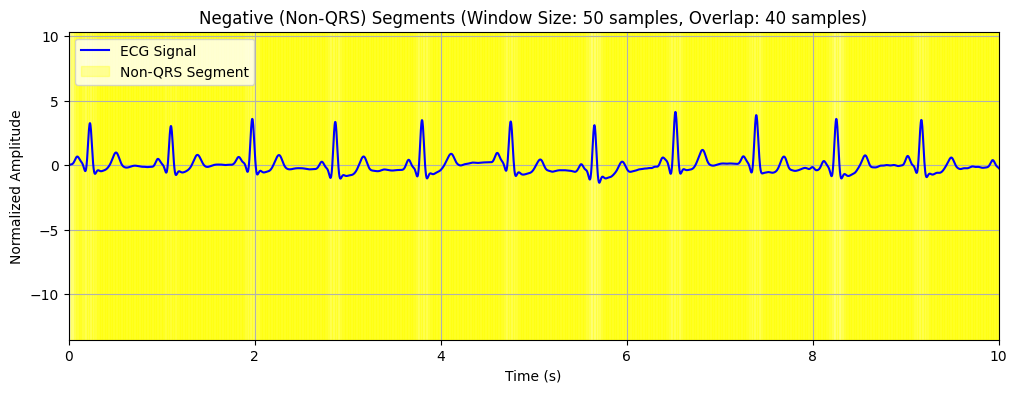

In [57]:
display_signal(0,10)

Number of positive (QRS) segments: 5747
Number of negative (non-QRS) segments: 59249


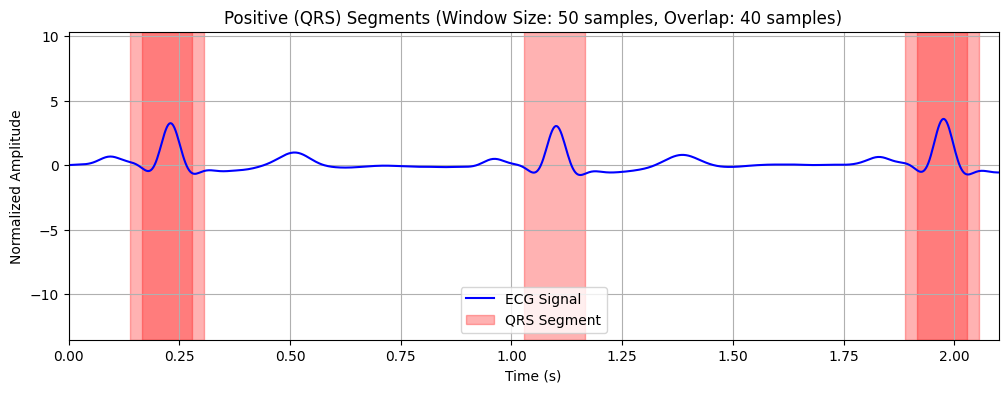

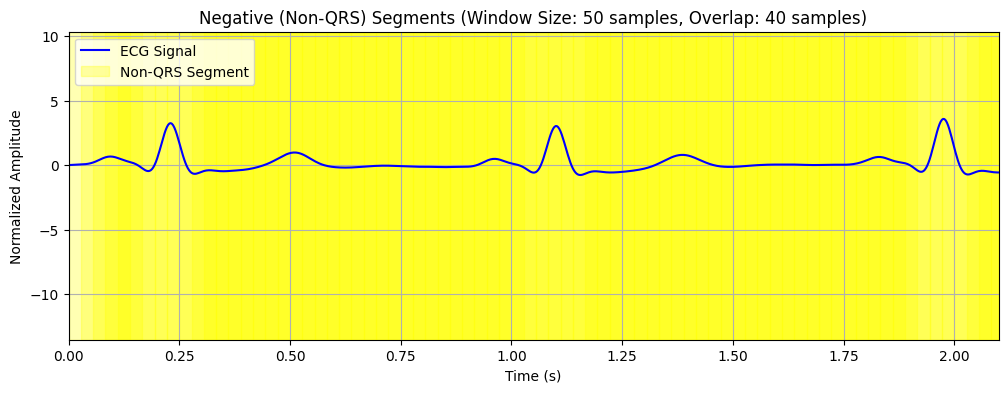

In [58]:
display_signal(0,2.1)

In [59]:
predicted_labels, new_segments, new_start_segments = remove_consecutive_ones(predicted_labels, new_segments, new_start_segments)
predicted_labels, new_segments, new_start_segments = remove_touching_negatives(predicted_labels, new_segments, new_start_segments)


Number of positive (QRS) segments: 1869
Number of negative (non-QRS) segments: 44323


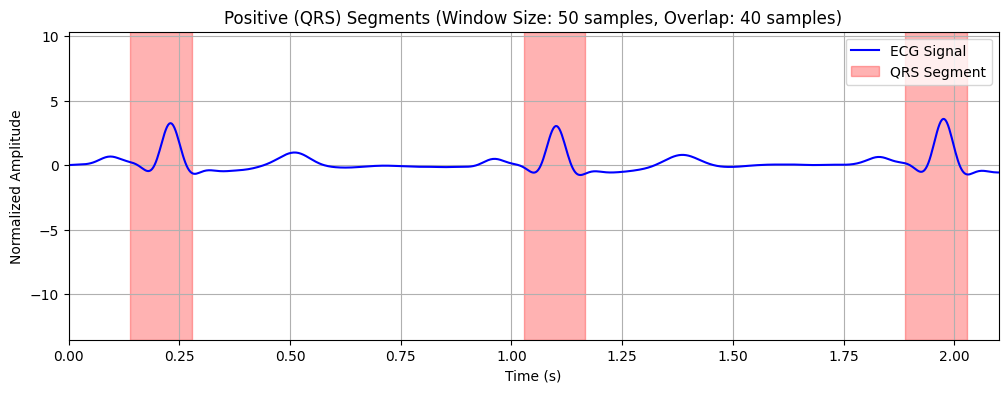

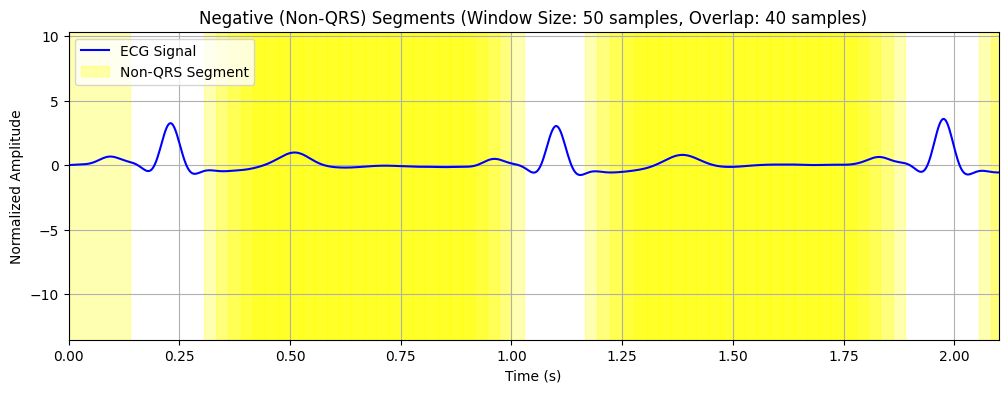

In [60]:
display_signal(0,2.1)
